# Explainable reasoning with ChiRho (categorical variables)

The **Explainable Reasoning with ChiRho** package aims to provide a systematic, unified approach to causal explanation computations in terms of different probabilistic queries over expanded causal models that are constructed from a single generic program transformation applied to an arbitrary causal model represented as a ChiRho program. The approach of reducing causal queries to probabilistic computations on transformed causal models is the foundational idea behind all of ChiRho. The key strategy underlying "causal explanation" queries is their use of auxiliary variables representing uncertainty about what the proposed interventions are and which interventions or preemptions to apply, implicitly inducing a search space over counterfactuals.

The goal of this notebook is to illustrate how the package can be used to provide an approximate method of answering a range of causal explanation queries with respect to models in which categorical variables play the key role. As the key tool will involve sampling-based posterior probability estimation, a lot of what will be said *mutatis mutandis* applies to more general settings where variables are continuous (to which we will devote another tutorial).

In yet [another notebook](https://basisresearch.github.io/chirho/actual_causality.html) we illustrate how the module allows for a faithful reconstruction of a particular notion of local explanation (the so-called Halpern-Pearl modified definition of actual causality [(J. Halpern, MIT Press, 2016)](https://mitpress.mit.edu/9780262537131/actual-causality/)), which inspired some of the conceptual steps underlying the current implementation.

**Outline**

[Causal explanation and counterfactual thinking](#causal-explanation-and-counterfactual-thinking)     


[Witness nodes and context sensitivity](#witness-nodes-and-context-sensitivity)

[Probability of causation and responsibility](#probability-of-causation-and-responsibility)

## Causal explanation and counterfactual thinking

Consider the following causality-related queries:

- **Friendly Fire:** On March 24, 2002, A B-52 bomber fired a Joint Direct Attack Munition at a US battalion command post, killing three and injuring twenty special forces soldiers. Out of multiple potential contributing factors, which were actually responsible for the incident?

- **Overshoot:** In dealing with an epidemic, multiple different policies were imposed, leading to the overshoot (the number of those who became infected after the peak of the epidemic) rising from around 15% in the unintervened model to around 25%. Which of the policies caused the overshoot and to what extent?

- **Explainable AI:** Your pre-trial release has been refused based on your [COMPAS score](https://en.wikipedia.org/wiki/COMPAS_(software)). The decision was made using a proprietary predictive model. All you have access to is the questionnaire that was used, and perhaps some demographic information about a class of human beings subjected to this evaluation. But which of these factors resulted in your score being what it is, and what were their contributions?


Questions of this sort are more local than those pertaining to average treatment effects, as they pertain to actual cases that come with their own contexts. Being able to answer them is useful for understanding how we can prevent undesirable outcomes similar to ones that we have observed, or promote the occurrence of desirable outcomes in contexts similar to the ones in which they had been observed. These context-sensitive causality questions are also an essential element of blame and responsibility assignments. If the phenomenon we're trying to explain is the behavior of a predictive model, we are dealing with a problem in explainable AI; but the underlying intuition behind the workings of **Explainable Reasoning with ChiRho** is that causally explaining the behavior of an opaque model is not that much different from providing a causal explanation of other real-world phenomena: we need to address such queries in a principled manner employing some approximate but hopefully reliable causal model of how things work (be that events outside of computers, or a predicitive model's behavior). **Explainable Reasoning with ChiRho** package aims to provide a unified general approach to the relevant causal explanation computations.

At some level of generality, a useful point of departure is a general counterfactual one. On one hand, we can ask whether the event would have occurred had a given candidate cause not taken place. This is sometimes called  the *but-for test*, has a tradition of being used as a tool for answering causality and attribution queries. 

- It is often used in [the law of torts](https://plato.stanford.edu/entries/causation-law/) to determine if a defendant's conduct was the cause of a particular harm. The test is often formulated as follows: "But for the defendant's conduct, would the harm have occurred?" 
- A major philosophical position in the analysis of causality is that the definition of causal dependence should be formulated in terms of counterfactual conditionals (Lewis, 1973. “Causation”, Journal of Philosophy, 70: 556–67). On this approach, $e$ causally depends on $c$ if and only if, if $c$ were not to occur $e$ would not occur. (The view does not remain uncontested, see the [SEP entry on counterfactual theories of causation](https://plato.stanford.edu/entries/causation-counterfactual/)).
- At least a few major approaches to explainable AI (such as [LIME](https://arxiv.org/abs/1602.04938),  or [Shapley values](https://papers.nips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html))  are based on the idea that explanations can be obtained by perturbing or shifting the input values and observing the changes in the output. This to a large extent can be thought of as a way of evaluating the but-for condition: if the input value was different, would the output value change? 
 
More generally, we can ask about the probability with which an alterantive intervention would lead to a cahnge in the outcome (perhaps while conditioning on other items of information), in line with the ideas present in Pearl's *Probabilities of causation...* and Chapter 9 of Pearl's *Causality*. While immensely useful, the but-for condition is not fine-grained enough to answer all the questions we are interested in or to give us the intended answers in cases in which the underlying causal model is non-trivial. We will illustrate this observation in this tutorial. 


On the other hand, we can ask whether given our model (and perhaps conditioning on other pieces of information we posses), intervening on a given candidate cause to have a given value results in the outcome being as observed (or, more generally, the probability of that outcome being as observed) - this is conceptually similar to Pearl's probability of sufficiency. 

We will start with these two approaches, but soon we will notice that often our explanatory questions are more local and a more fine-grained tool is needed. The general intuition (inspired by Halpern's *Actual Causality*) that we implemented is that when we ask local explanatory questions, we need to keep some part of the actual context fixed and consider alternative scenarios insofar as potential causes are involved. That is, we (i) search through possible alternative interventions that could be performed on the candidate cause nodes, (ii) search through possible context nodes that are to be intervened to be at their factual values even in the counterfactual worlds, (iii) see how these options play out in intervened worlds, and (iv) investigate and meaningfully summarize what happens with the outcome nodes of interest in all those counterfactual worlds. 

Let's start with a very simple model, in which a forest fire can be caused by exactly one of two things: a match being dropped (`match_dropped`), or a lightning strike (`lightning`), and either of these factors alone is already deterministically sufficient for the `forest_fire` to occur. A match being dropped is more likely than a lightning strike (we use fairly large probabilities for the sake of example transparency). For the sake of illustration, we also include a causally irrelevant site representing whether a ChiRho developer smiles, `smile`.

In [1]:
%env CUDA_VISIBLE_DEVICES=-1

from functools import partial
from typing import Callable, Dict, List, Optional

import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import seaborn as sns
import torch
from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.explainable.handlers import SearchForExplanation
from chirho.indexed.ops import IndexSet, gather
from chirho.observational.handlers import condition

pyro.settings.set(module_local_params=True)

env: CUDA_VISIBLE_DEVICES=-1


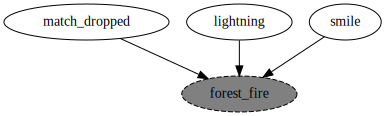

In [2]:
def ff_disjunctive():
    match_dropped = pyro.sample(
        "match_dropped", dist.Bernoulli(0.7)
    )  # notice uneven probs here
    lightning = pyro.sample("lightning", dist.Bernoulli(0.4))

    # this is a causally irrelevant site
    smile = pyro.sample("smile", dist.Bernoulli(0.5))

    forest_fire = pyro.deterministic(
        "forest_fire", torch.max(match_dropped, lightning) + (0 * smile), event_dim=0
    )

    return {
        "match_dropped": match_dropped,
        "lightning": lightning,
        "forest_fire": forest_fire,
    }

ff_node_names = ["smile", "match_dropped", "lightning", "forest_fire"]

pyro.render_model(ff_disjunctive)

First, suppose we are interested in asking the question of whether dropping a match has causal power over whether the forest fire occurs. We assume all relevant nodes are binary. The potential cause (`antecedent`) we're considering is `match_dropped=1`, we contrast it with what would happen if we intervened on it to not happen (`alternatives`). We are interested in whether an outcome variable (`consequent`) has value 1 under these two interventions. The counterfactual world in which we intervene with `alternatives` is world 1, and the counterfactual world in which we intervene with `antecedents` is world 2. We will be interested in cases in which none of these interventions have been preempted (more about this later), so we will sample with appropriate masks as well.

In [3]:
supports = {key: constraints.boolean for key in ff_node_names}
antecedents = {"match_dropped": torch.tensor(1.0)}
alternatives = {"match_dropped": torch.tensor(0.0)}
consequents = {"forest_fire": torch.tensor(1.0)}


masks = {
    "match_dropped": {"value": torch.tensor(0.0), "world": 1},
    "match_dropped": {"value": torch.tensor(1.0), "world": 2},
}

We we will first wrap our model in the `SearchForExplanation` handler, which expands the original model to allow for our exploration of the counterfactual scenarios, and then use rejection sampling employing the relevant masks.

In [4]:
class RejectionSampler(torch.nn.Module):
    """
    A class to sample explanations from a given probabilistic model.

    Attributes:
    model (Callable): A model to sample from.
    num_samples (int, optional): The number of samples to draw from the model. Default is 5.
    world_dim (int, optional): Location of the world dimension. Default is -5.

    Methods:
    forward(mask: Optional[Dict[str, torch.Tensor]] = None,
            sites: Optional[List] = None, *args, **kwargs):
        Samples from the model with `MultiWorldCounterfactual` and `pyro.plate`,
        applies a mask to filter the trace, and replays the model
        with the resulting trace.
    """

    def __init__(self, model: Callable, num_samples: int = 5, world_dim: int = -5):
        super(RejectionSampler, self).__init__()
        self.model = model
        self.num_samples = num_samples
        self.world_dim = world_dim

    def forward(
        self,
        masks: Optional[Dict[str, torch.Tensor]] = None,
        *args,
        **kwargs
    ):
        with MultiWorldCounterfactual() as mwc:
            with pyro.plate("samples", size=self.num_samples):
                output, trace = self.model(*args, **kwargs)

        trace.trace.compute_log_prob()
        nodes = trace.trace.nodes

        joint_mask = torch.ones(self.num_samples).bool()

        if masks is not None:
            for key in masks.keys():
                if "world" not in masks[key]:
                    joint_mask = joint_mask * (
                        nodes[key]["value"] == masks[key]["value"]
                    )
                else:
                    # this assumes the world index is not preceded by any other index
                    # is this a safe simplification?
                    to_filter = nodes[key]["value"][masks[key]["world"], ...].flatten()
                    joint_mask = joint_mask * (to_filter == masks[key]["value"])

        for key in nodes.keys():

            if not key.startswith("__cause____consequent"):
                to_mask = nodes[key]["value"]
                if to_mask.shape != torch.Size([]):
                    masked = to_mask[..., joint_mask]
                    nodes[key]["value"] = masked

        with pyro.poutine.replay(trace=trace.trace):
            with MultiWorldCounterfactual() as new_mwc:
                with pyro.poutine.trace() as new_trace:
                    output = self.model(*args, **kwargs)

        new_trace.trace.compute_log_prob()

        return output, new_trace, new_mwc

In [5]:
# to avoid repetition, we define a wrapper function for inference

def infer_intervened(
    model,
    num_samples,
    masks,
    supports,
    observations,
    antecedents,
    alternatives,
    witnesses,
    consequents,
    *args,
    **kwargs
):

    # wrap model in our handler, passing appropriate arguments
    def wrapped_model(*args, **kwargs):
        with SearchForExplanation(
            supports=supports,
            antecedents=antecedents,
            alternatives=alternatives,
            witnesses=witnesses,
            consequents=consequents,
        ):
            with condition(data=observations):
                with pyro.poutine.trace() as tr:
                    return model(*args, **kwargs), tr

    # instantiate the sampler and run it, returning the output, trace, 
    # and the multiworld counterfactual object to help us track what happens in different
    # counterfactual worlds 
    sampler = RejectionSampler(wrapped_model, num_samples=num_samples)
    output, trace, mwc = sampler(masks=masks, *args, **kwargs)
    return output, trace, mwc

In [6]:
# it will also be useful to have a function to plot the results of our inference

def intervened_plot(
    mwc,
    nodes,
    antecedent_sites,
    outcome_site,
    mask=None,
    title=None,
):

    index_sets = [IndexSet(**{a: {n} for a in antecedent_sites}) for n in range(3)]
    with mwc:
        necessity = gather(nodes[outcome_site]["value"], index_sets[1]).flatten()
        sufficiency = gather(nodes[outcome_site]["value"], index_sets[2]).flatten()

    if mask is not None:
        necessity = necessity[mask]
        sufficiency = sufficiency[mask]

    nec_and_suff = (1 - necessity) * sufficiency

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 5))

    ax0.hist(nec_and_suff, bins=[-0.5, 0.5, 1.5], alpha=0.5, density=True)
    ax0.set_title(
        "both\n change if do(alternative), ...\n and no change if do(antecedent), ..."
    )
    ax0.set_xticks([0, 1])
    ax0.set_xticklabels(["False", "True"])

    ax1.hist(necessity, bins=[-0.5, 0.5, 1.5], alpha=0.5, density=True)
    ax1.set_title("change to outcome if\n do(antecedent=alternative), ...")
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(["change", "no change"])

    ax2.hist(sufficiency, bins=[-0.5, 0.5, 1.5], alpha=0.5, density=True)
    ax2.set_title("change to outcome if\n do(antecedent=antecedent), ...")
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels(["change", "no change"])

    fig.suptitle(title)

    sns.despine()
    plt.tight_layout()
    plt.show()

In [7]:
# to decrease boilerplate, we define a partial function

forest_fire_infer_partial = partial(
    infer_intervened,
    model=ff_disjunctive,
    num_samples=10000,
    masks=masks,
    supports=supports,
    observations={},
    antecedents=antecedents,
    alternatives=alternatives,
    witnesses={}, # potential context elements, we leave them empty for now
    consequents=consequents,
)


Throughout this tutorial, we assume all nodes are binary and use $'$ as negation. Once we specify (i) the distributions for the nodes we use (`supports`), (ii) candidate causes $X_i = x_i$ (`antecedents`) (iii) their alternative values ($X_i = x_i'$), (iv) elements of the current context (`witnesses`), and  (v) the `consequents` of interest $Y=y$. The  `SearchForExplanation` handler transforms the original model into one in which interventions and alternative interventions on the antecedents are applied in parallel counterfactual worlds stochastically preempted and context elements are stochastically selected and preempted to be kept at the factual values in all counterfactual worlds.

First, let's go back to our original query. Let $F$ be the `forest_fire`, $f$ stand for $F=1$, $f'$ for $F=0$, $M$ stand for `match_dropped`, with analogous conventions. We also place interventions conditioned on in subscripts, so that, for example
$P(f_m')$ stands for $P(F=1\vert do(M=0))$. We are currently interested in three things:

- $P(f'_{m'}, f_m)$, that is the probability of both forest fire not occurring if we intervene on the match to not be dropped, and forest fire occurring if we intervene on the match to be dropped. This estimation is first from the left on our plot. We leave the `...` in the subtitles as we will be adding conditions as we move forward, and we will make it clear from the context what the conditions are.
- $P(f'_{m'})$, the probability that intervening on the match to not be dropped would prevent the fire. This is in the center of the plot, and we see that 40% of the time it wouldn't, as this is the frequency at which a lightninig is assumed to occur and deterministically cause the fire.
- $P(f_m)$, the probability that intervening on the match to be dropped would result in a fire. This is on the right-hand side of the plot, and as our model is rather trivial and deterministic, this probability is one. 

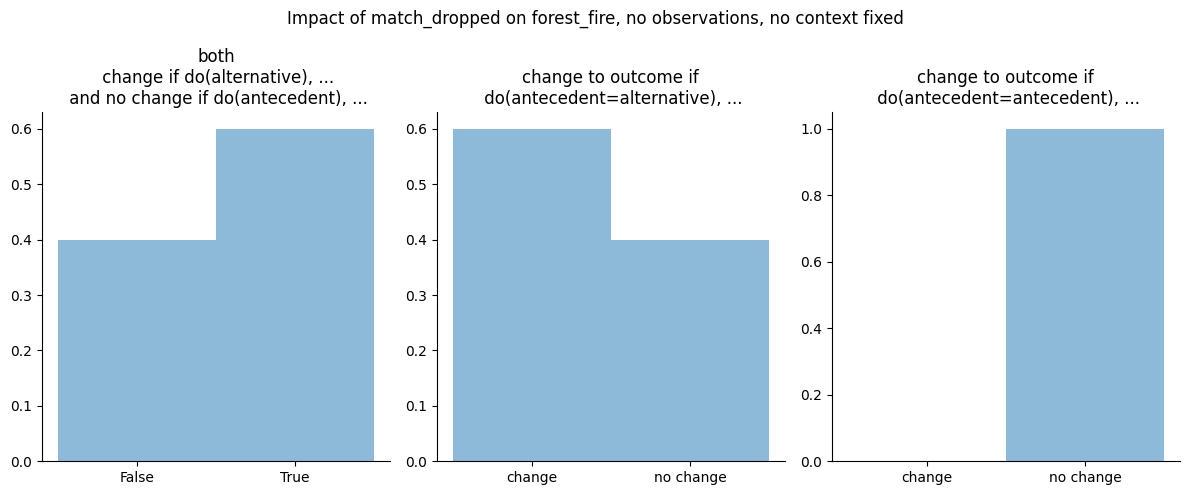

In [8]:
output, trace, mwc = forest_fire_infer_partial()

intervened_plot(
    mwc=mwc,
    nodes=trace.trace.nodes,
    antecedent_sites=["match_dropped"],
    outcome_site="forest_fire",
    title="Impact of match_dropped on forest_fire, no observations, no context fixed",
)

Let's push further with the idea that we can extend the assumptions to obtain answers to more localized queries and still estimate counterfactual distributions of outcome variables. For instance, we can ask an analogous question in a situation in which in fact a match has been dropped, but there was no lightning. Somewhat unsurprisingly, in this case, $P(f'_{m'}\vert m, l') =1$ as no alternative cause of fire is active or can be activated by $do(m')$.

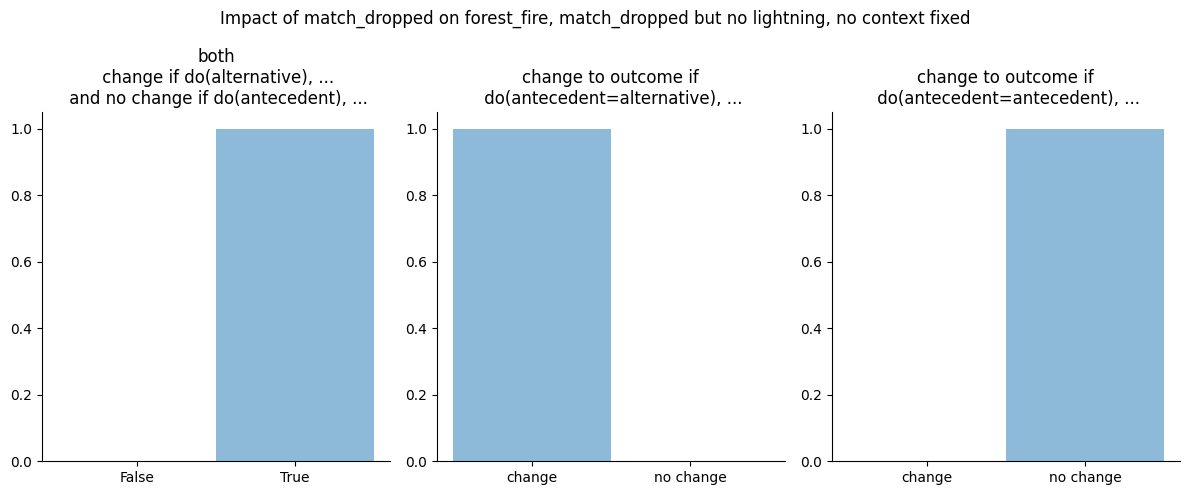

In [9]:
output, trace, mwc = forest_fire_infer_partial(
    observations={"match_dropped": torch.tensor(1.0), "lightning": torch.tensor(0.0)}
)

intervened_plot(
    mwc=mwc,
    nodes=trace.trace.nodes,
    antecedent_sites=["match_dropped"],
    outcome_site="forest_fire",
    title="Impact of match_dropped on forest_fire, match_dropped but no lightning, no context fixed",
)

More interestingly, in cases of overdetermination, a similar estimation would lead us to assign no causal role to any of to co-contributing factors. This can be seen in the context in which both causes occurred. Trivially, if lightning occurred, then had no match been dropped, the forest fire, caused by lighning, would still occur (a symmetric reasoning goes through for the lightning as well), $P(f'_{m'}\vert m, l) = P(f'_{l'}\vert m, l)=0$. Intuitively, these quantities are not good guides to the causal role of `match_dropped` and `lightning`, as we think they did played a causal role. This is the first illustration of why the but-for analysis is not fine-grained enough.

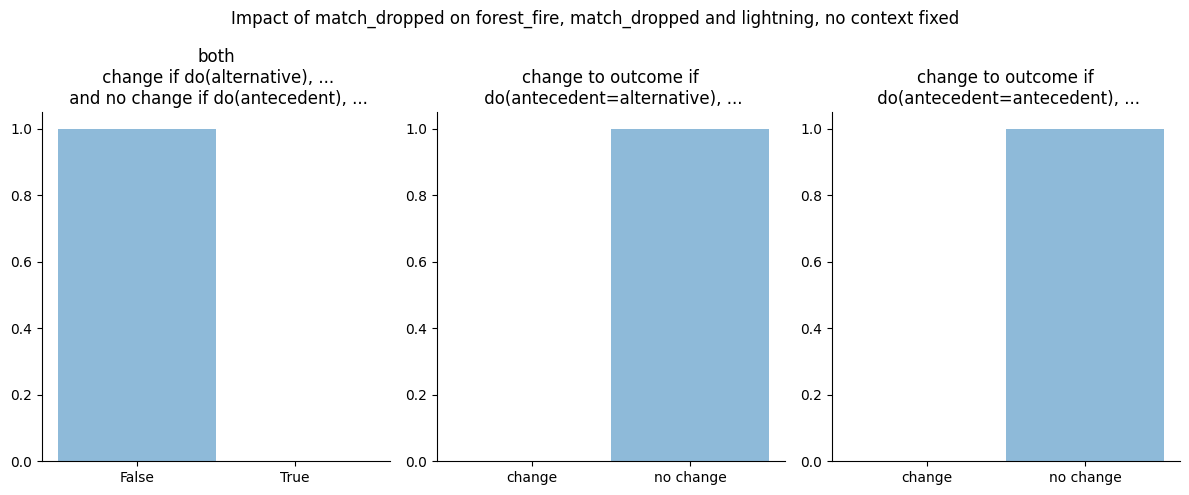

In [10]:
output, trace, mwc = forest_fire_infer_partial(
    observations={"match_dropped": torch.tensor(1.0), "lightning": torch.tensor(1.0)}
)

intervened_plot(
    mwc=mwc,
    nodes=trace.trace.nodes,
    antecedent_sites=["match_dropped"],
    outcome_site="forest_fire",
    title="Impact of match_dropped on forest_fire, match_dropped and lightning, no context fixed",
)

## Witness nodes and context sensitivity

Some of these intuitions in the forest fire example may be salvaged by considering a two-membered antecedent set, estimating
$P(f'_{m',l'}, f_{m,l}), P(f'_{m',l'}),$ and $P(f_{m,l})$.  

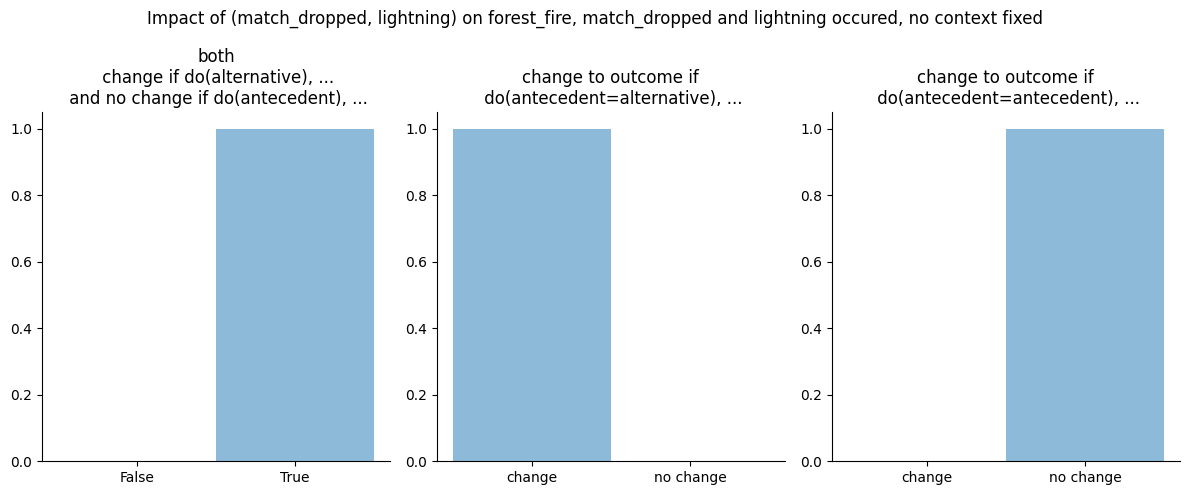

In [11]:
output, trace, mwc = forest_fire_infer_partial(
    observations={"match_dropped": torch.tensor(1.0), "lightning": torch.tensor(1.0)},
    antecedents={"match_dropped": 1.0, "lightning": 1.0},
    alternatives={"match_dropped": 0.0, "lightning": 0.0},
    masks={
        "match_dropped": {"value": torch.tensor(0.0), "world": 1},
        "match_dropped": {"value": torch.tensor(1.0), "world": 2},
        "lightning": {"value": torch.tensor(0.0), "world": 1},
        "lightning": {"value": torch.tensor(1.0), "world": 2},
    },
)

intervened_plot(
    mwc=mwc,
    nodes=trace.trace.nodes,
    antecedent_sites=["match_dropped", "lightning"],
    outcome_site="forest_fire",
    title="Impact of (match_dropped, lightning) on forest_fire, match_dropped and lightning occured, no context fixed",
)

This already suggests a more complicated picture, as it turns out that we need to pay attention to membership in larger antecedent sets that would make a difference (that is one reason why we need stochasticity in antecedent candidate preemption: to search for such sets).

But even then, the but-for analysis does not pay sufficient attention to the granularity of a given problem and its causal structure. There are asymmetric cases where the efficiency of one cause prevents the efficiency of another, in which our causal attributions should also be asymmetric, but "being a member of the same larger antecedent set" isn't.

A simple example is breaking a bottle. Suppose Sally and Bob throw a rock at a bottle, and Sally does so a little earlier than Bob. Suppose both are perfectly accurate, and the bottle shatters when hit. Sally hits, and the bottle shatters, but Bob doesn't hit it because the bottle is no longer there.  

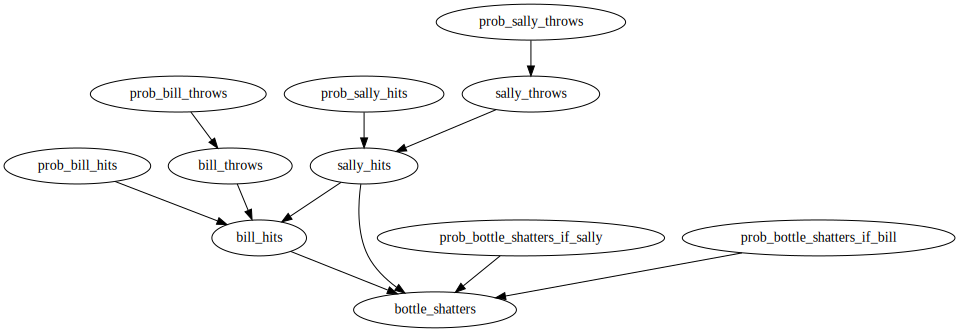

In [12]:
def stones_model():
    prob_sally_throws = pyro.sample("prob_sally_throws", dist.Beta(1, 1))
    prob_bill_throws = pyro.sample("prob_bill_throws", dist.Beta(1, 1))
    prob_sally_hits = pyro.sample("prob_sally_hits", dist.Beta(1, 1))
    prob_bill_hits = pyro.sample("prob_bill_hits", dist.Beta(1, 1))
    prob_bottle_shatters_if_sally = pyro.sample(
        "prob_bottle_shatters_if_sally", dist.Beta(1, 1)
    )
    prob_bottle_shatters_if_bill = pyro.sample(
        "prob_bottle_shatters_if_bill", dist.Beta(1, 1)
    )

    sally_throws = pyro.sample("sally_throws", dist.Bernoulli(prob_sally_throws))
    bill_throws = pyro.sample("bill_throws", dist.Bernoulli(prob_bill_throws))

    # if Sally throws, she hits with probability prob_sally_hits
    # hits with pr=0 otherwise
    new_shp = torch.where(sally_throws == 1, prob_sally_hits, 0.0)

    sally_hits = pyro.sample("sally_hits", dist.Bernoulli(new_shp))

    # if Bill throws, he hits with probability prob_bill_hits
    # if sally doesn't hit sooner,
    # misses otherwise
    new_bhp = torch.where(
        bill_throws.bool() & (~sally_hits.bool()),
        prob_bill_hits,
        torch.tensor(0.0),
    )

    bill_hits = pyro.sample("bill_hits", dist.Bernoulli(new_bhp))

    # you can use a analogous move to model the bottle shattering
    # if being hit by a stone doesn't deterministically
    # shatter the bottle
    new_bsp = torch.where(
        bill_hits.bool(),
        prob_bottle_shatters_if_bill,
        torch.where(
            sally_hits.bool(),
            prob_bottle_shatters_if_sally,
            torch.tensor(0.0),
        ),
    )

    bottle_shatters = pyro.sample("bottle_shatters", dist.Bernoulli(new_bsp))

    return {
        "sally_throws": sally_throws,
        "bill_throws": bill_throws,
        "sally_hits": sally_hits,
        "bill_hits": bill_hits,
        "bottle_shatters": bottle_shatters,
    }


stones_model.nodes = [
    "sally_throws",
    "bill_throws",
    "sally_hits",
    "bill_hits",
    "bottle_shatters",
]


pyro.render_model(stones_model)

For now let us assume that the relevant probabilities are 1 (this forces both Sally and Bill to throw stones, makes them perfectly accurate and makes the bottle always shatter if hit). Let us start with the type of analysis we performed for the forest fire case. 

In [13]:
supports = {
    "sally_throws": constraints.boolean,
    "bill_throws": constraints.boolean,
    "sally_hits": constraints.boolean,
    "bill_hits": constraints.boolean,
    "bottle_shatters": constraints.boolean,
}

antecedents = {"sally_throws": torch.tensor(1.0)}
alternatives = {"sally_throws": torch.tensor(0.0)}

observation_keys = [
    "prob_sally_throws",
    "prob_bill_throws",
    "prob_sally_hits",
    "prob_bill_hits",
    "prob_bottle_shatters_if_sally",
    "prob_bottle_shatters_if_bill",
]
observations = {k: torch.tensor(1.0) for k in observation_keys}

consequents = {"bottle_shatters": torch.tensor(1.0)}

masks = {
    "sally_throws": {"value": torch.tensor(0.0), "world": 1},
    "sally_throws": {"value": torch.tensor(1.0), "world": 2},
}

stone_throwing_infer_partial = partial(
    infer_intervened,
    model=stones_model,
    num_samples=15,
    masks=masks,
    supports=supports,
    observations=observations,
    antecedents=antecedents,
    alternatives=alternatives,
    witnesses={},
    consequents=consequents,
)

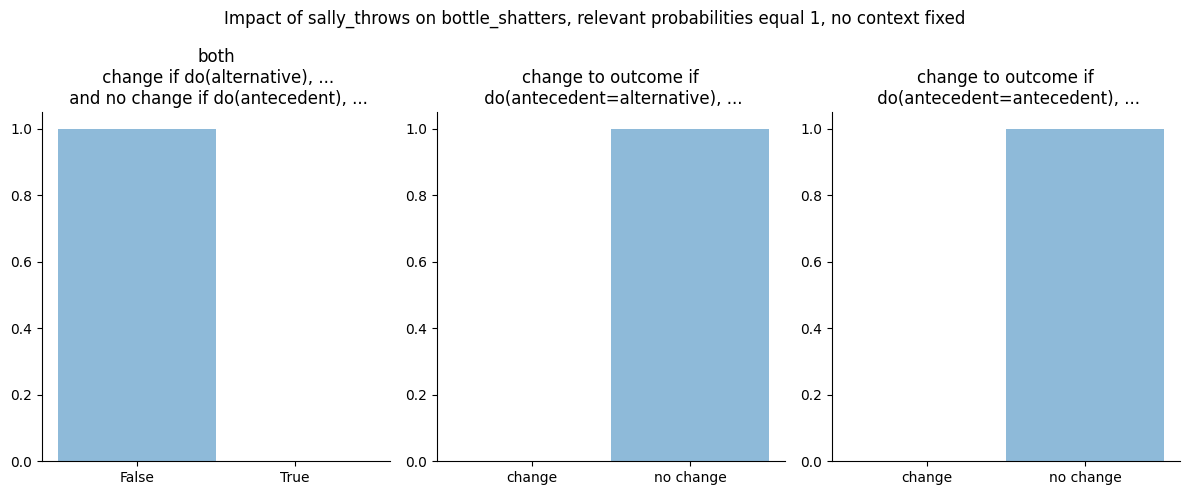

In [14]:
output, trace, mwc = stone_throwing_infer_partial()

intervened_plot(
    mwc=mwc,
    nodes=trace.trace.nodes,
    antecedent_sites=["sally_throws"],
    outcome_site="bottle_shatters",
    title="Impact of sally_throws on bottle_shatters, relevant probabilities equal 1, no context fixed",
)

Sally's throw does not satisfy the but-for condition: if she hadn't thrown the rock, the bottle would still have shattered. Of course, the combined event of Sally throwing a rock and Bob throwing a rock is a but-for cause of the bottle shattering. But that doesn't capture the clear asymmetry at work here. Intuitively, Sally's throw is the (actual) cause of the bottle breaking in a way that Bob's throw isn't.  Sally's throw actually caused the bottle to shatter and Bob's throw didn't, in part because Bob's stone didn't actually hit the bottle.

An intuitive solution to the problem, inspired by the  Pearl-Halpern definition of actual causality (which we discuss in [another notebook](https://basisresearch.github.io/chirho/actual_causality.html)) is to say that **in answering actual causality queries, we need to consider what happens when part of the actual context is kept fixed.** For instance, in the bottle shattering example, given the observed fact that Bob’s stone didn’t hit, in the counterfactual world in which we keep this observed fact fixed, if Sally nad not thrown the stone, the bottle in fact would not have shattered. 


For this reason, our handler allows not only stochastic preemption of interventions (to approximate the search through possible antecedent sets) but also stochastic witness preemption of those nodes that are considered part of the context (these needn't exclude each other). In a witness preemption, we ensure that the counterfactual value is identical to the factual one (and by applying it randomly to candidate witness nodes, we approximate a search through all possible context sets).

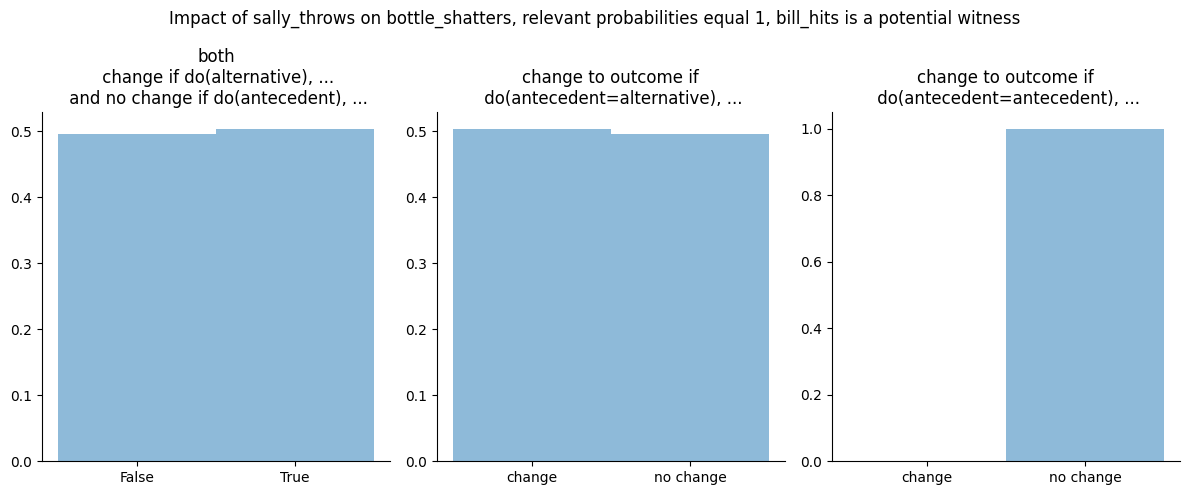

In [15]:
output, trace, mwc = stone_throwing_infer_partial(
    num_samples=10000,
    witnesses={
        "bill_hits": constraints.boolean,
    }
)

intervened_plot(
    mwc=mwc,
    nodes=trace.trace.nodes,
    antecedent_sites=["sally_throws"],
    outcome_site="bottle_shatters",
    title="Impact of sally_throws on bottle_shatters, relevant probabilities equal 1, bill_hits is a potential witness",
)

Admittedly, our search through contexts is very simple and degenerate, as the only part of the actual context which stochastically is kept fixed at the factual value is `bill_hits`. But already with this search, sally throwing is diagnosed as having non-null probability. In fact, the definition of actual causality in Halpern's book (*Actual causality*) contains an existential quantifier: a variable is an actual cause if there is at least one context in which a change in the outcome variable would result from changing the antecedent to have an alternative value, so our search provides a correct diagnosis here.

In the above, we sample potential witness sets, and there is only one of them. The probability of its being fixed at the actual value is 0.5, and in that context, changing the value of the antecedent would have made a difference, which is mirrored in our posterior counterfactual distribution estimate also being close to 0.5.

Crucally, as intended, an analogous inference for whether `bill_throws` is a cause of the bottle shattering, yields a different
result and assigns null causal role to bill.

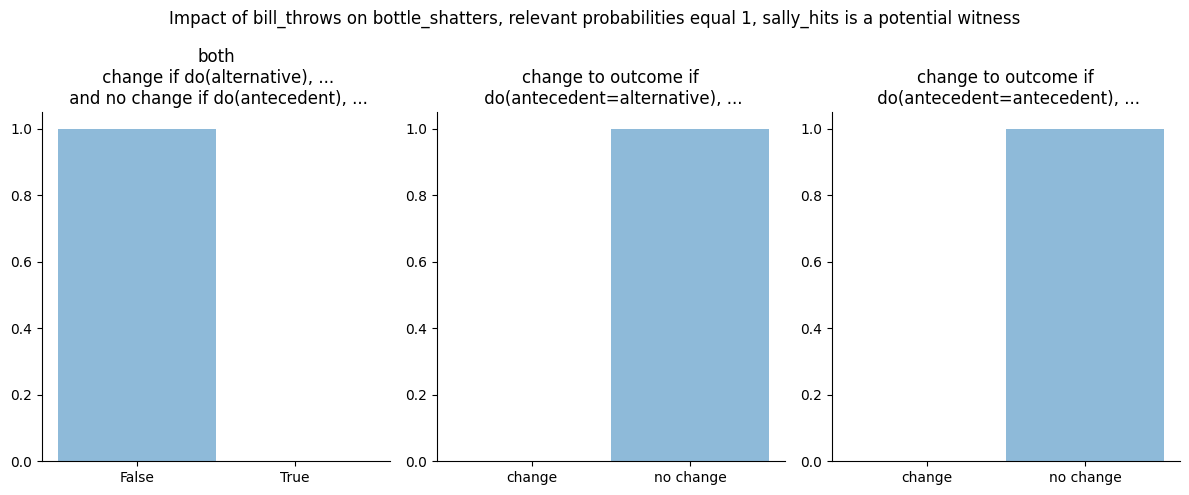

In [18]:
output, trace, mwc = stone_throwing_infer_partial(
     num_samples=10000,
     masks = {
    "bill_throws": {"value": torch.tensor(0.0), "world": 1},
    "bill_throws": {"value": torch.tensor(1.0), "world": 2},
},

antecedents = {"bill_throws": torch.tensor(1.0)},
alternatives = {"bill_throws": torch.tensor(0.0)},
witnesses={
        "sally_hits": constraints.boolean,
    }
)


intervened_plot(
    mwc=mwc,
    nodes=trace.trace.nodes,
    antecedent_sites=["sally_throws"],
    outcome_site="bottle_shatters",
    title="Impact of bill_throws on bottle_shatters, relevant probabilities equal 1, sally_hits is a potential witness",
)


## Probability of causation and responsibility

We might use non-trivial probabilities and be interested in more involved queries. Suppose we aren't sure what part of the context we want to hold fixed, allowing both `sally_hits` and `bill_hits` to be witness candidates, so we attach equal weights to all four possible context sets. 

Suppose also that beyond knowing the non-degenerate probabilities involved, we don't know who threw the stone, and we only observed the bottle has been shattered. We can use the handler to estimate the answer to a somewhat different question involving the probabilities that changing the value of `sally_throws` or changing the value of `billy_throws` (whatever these are in the factual world) would lead to a change in the outcome variables, and that fixing them to be at the factual values would result in the outcome variable having the same value. We also allow both `sally_hits` and `bill_hits` as potential witnesses.


Let $x_f/x_{alt}, x_{ant}$ stand for the factual, alternative-intervened and antecedent-intervened values of $x$. Let also $\vec{p}$ stand for all the probabilities in the model having the values as specified in the chunk below. Each potential witness node $w$ comes with an associated preemption variable $preempt(w)$, so that $w$ is intervened to have the factual value ($do(w  = w_f)$) if $preempt(w)$=1. Thus we have a variable that generates witness interventions $WitnessPreemptions = \{do(w = w_f) \vert preempt(w) =1 \}$. We can sample to estimate quantities such as $P(bs_o\neq bs_{alt}, bs_o = bs_{ant} \vert bs, \vec{p}, WitnessPreemptions)$. We do this as follows.

In [16]:
output, trace, mwc = stone_throwing_infer_partial(
    num_samples=20000,
    observations={
        "prob_sally_throws": torch.tensor(0.8),
        "prob_bill_throws": torch.tensor(0.7),
        "prob_sally_hits": torch.tensor(0.9),
        "prob_bill_hits": torch.tensor(0.8),
        "prob_bottle_shatters_if_sally": torch.tensor(0.9),
        "prob_bottle_shatters_if_bill": torch.tensor(0.8),
        # we want to explain the bottle shattering
        "bottle_shatters": torch.tensor(1.0),
    },
    masks={},
    antecedents={"sally_throws": None, "bill_throws": None},
    alternatives=None,  
    witnesses={"sally_hits": None, "bill_hits": None},
    consequents={"bottle_shatters": None},
)

In [17]:
# here conditions cut across counterfactual world, so we're masking after sampling
# with no masks. An alternative would be to make RejectionSampler more flexible

# we also will be continioning on "internal" nodes which record whether a given node
# has been preempted (intervened to have the observed value)

# st, sh, bt, bh stand for sally_throws, sally_hits, bill_throws, bill_hits

with mwc:
    st_observed = gather(
        trace.trace.nodes["sally_throws"]["value"], IndexSet(sally_throws={0})
    ).flatten()

    st_alternative = gather(
        trace.trace.nodes["sally_throws"]["value"], IndexSet(sally_throws={1})
    ).flatten()

    st_antecedent = gather(
        trace.trace.nodes["sally_throws"]["value"], IndexSet(sally_throws={2})
    ).flatten()

    sally_throws_mask = (st_observed != st_alternative) & (st_observed == st_antecedent)

    bt_observed = gather(
        trace.trace.nodes["bill_throws"]["value"], IndexSet(bill_throws={0})
    ).flatten()

    bt_alternative = gather(
        trace.trace.nodes["bill_throws"]["value"], IndexSet(bill_throws={1})
    ).flatten()

    bt_antecedent = gather(
        trace.trace.nodes["bill_throws"]["value"], IndexSet(bill_throws={2})
    ).flatten()

    bill_throws_mask = (bt_observed != bt_alternative) & (bt_observed == bt_antecedent)

    bottle_shatters_observed = gather(
        trace.trace.nodes["bottle_shatters"]["value"],
        IndexSet(sally_throws={0}, bill_throws={0}),
    ).flatten()

    bottle_shatters_alternative = gather(
        trace.trace.nodes["bottle_shatters"]["value"],
        IndexSet(sally_throws={1}, bill_throws={1}),
    ).flatten()

    bottle_shatters_antecedent = gather(
        trace.trace.nodes["bottle_shatters"]["value"],
        IndexSet(sally_throws={2}, bill_throws={2}),
    ).flatten()

bottle_alternative_sally = (
    bottle_shatters_alternative[sally_throws_mask]
    != bottle_shatters_observed[sally_throws_mask]
).float()
bottle_antecedent_sally = (
    bottle_shatters_antecedent[sally_throws_mask]
    == bottle_shatters_observed[sally_throws_mask]
).float()
bottle_joint_sally = bottle_alternative_sally * bottle_antecedent_sally


bottle_alternative_bill = (
    bottle_shatters_alternative[bill_throws_mask]
    != bottle_shatters_observed[bill_throws_mask]
).float()
botle_antecedent_bill = (
    bottle_shatters_antecedent[bill_throws_mask]
    == bottle_shatters_observed[bill_throws_mask]
).float()
bottle_joint_bill = bottle_alternative_bill * botle_antecedent_bill

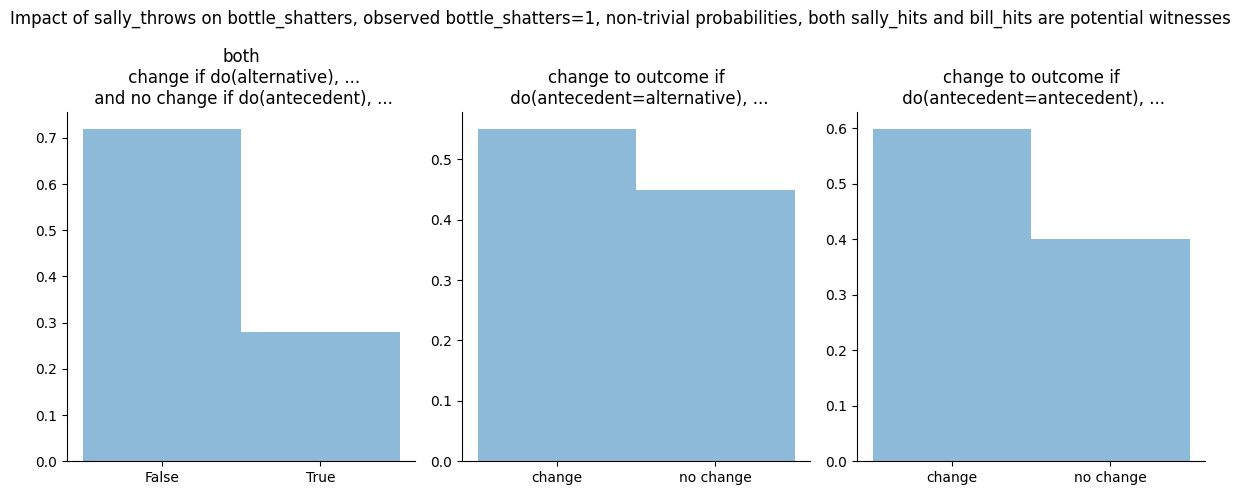

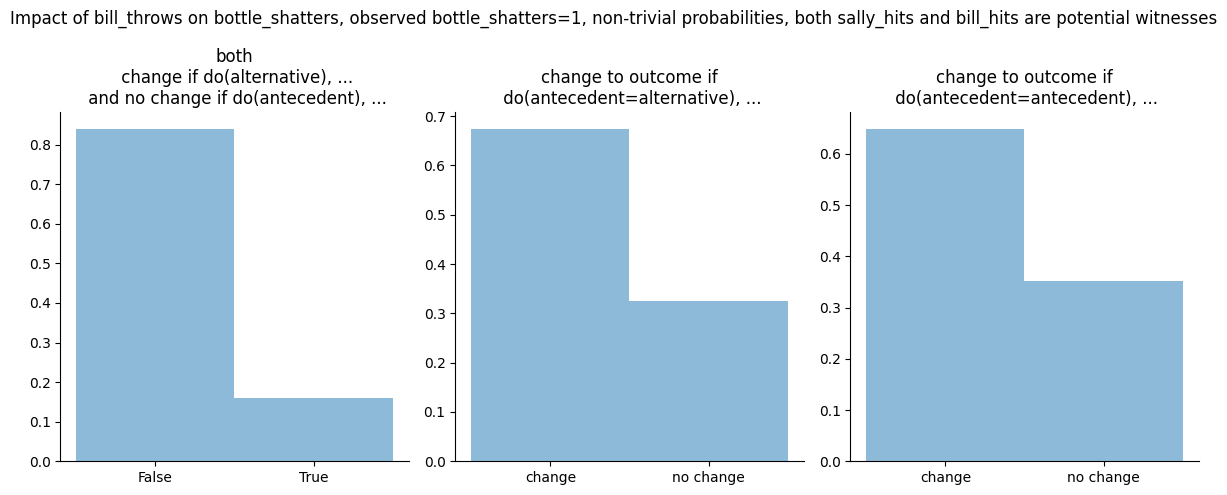

In [18]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 5))

ax0.hist(bottle_joint_sally, bins=[-0.5, 0.5, 1.5], alpha=0.5, density=True)
ax0.set_title(
    "both\n change if do(alternative), ...\n and no change if do(antecedent), ..."
)
ax0.set_xticks([0, 1])
ax0.set_xticklabels(["False", "True"])

ax1.hist(bottle_alternative_sally, bins=[-0.5, 0.5, 1.5], alpha=0.5, density=True)
ax1.set_title("change to outcome if\n do(antecedent=alternative), ...")
ax1.set_xticks([0, 1])
ax1.set_xticklabels(["change", "no change"])

ax2.hist(bottle_antecedent_sally, bins=[-0.5, 0.5, 1.5], alpha=0.5, density=True)
ax2.set_title("change to outcome if\n do(antecedent=antecedent), ...")
ax2.set_xticks([0, 1])
ax2.set_xticklabels(["change", "no change"])

fig.suptitle(
    "Impact of sally_throws on bottle_shatters, observed bottle_shatters=1, non-trivial probabilities, both sally_hits and bill_hits are potential witnesses"
)

sns.despine()
plt.tight_layout()
plt.show()

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 5))

ax0.hist(bottle_joint_bill, bins=[-0.5, 0.5, 1.5], alpha=0.5, density=True)
ax0.set_title(
    "both\n change if do(alternative), ...\n and no change if do(antecedent), ..."
)
ax0.set_xticks([0, 1])
ax0.set_xticklabels(["False", "True"])

ax1.hist(bottle_alternative_bill, bins=[-0.5, 0.5, 1.5], alpha=0.5, density=True)
ax1.set_title("change to outcome if\n do(antecedent=alternative), ...")
ax1.set_xticks([0, 1])
ax1.set_xticklabels(["change", "no change"])

ax2.hist(botle_antecedent_bill, bins=[-0.5, 0.5, 1.5], alpha=0.5, density=True)
ax2.set_title("change to outcome if\n do(antecedent=antecedent), ...")
ax2.set_xticks([0, 1])
ax2.set_xticklabels(["change", "no change"])

fig.suptitle(
    "Impact of bill_throws on bottle_shatters, observed bottle_shatters=1, non-trivial probabilities, both sally_hits and bill_hits are potential witnesses"
)

sns.despine()
plt.tight_layout()
plt.show()

Note that we assumed Sally to be more likely to throw, more likely to hit, and more likely to shatter the bottle if she hits. For this reason, we expect her to be more likely to be causally responsible for the outcome. Conceptually, these estimates are impacted by some hyperparameters, such as witness preemption probabilities, so perhaps a bit more clarity on can be gained if we think we have a complete list of potential causes and normalize. 

In [20]:
probability_of_change_alternative_sally = torch.mean(bottle_alternative_sally)
probability_of_no_change_antecedent_sally = torch.mean(bottle_antecedent_sally)
probability_of_both_sally = torch.mean(bottle_joint_sally)

print("Sally")

print(
    f"Probability of change if do(antecedent=alternative): {probability_of_change_alternative_sally:.2f}"
)
print(
    f"Probability of no change if do(antecedent=antecedent): {probability_of_no_change_antecedent_sally:.2f}"
)
print(f"Probability of both: {probability_of_both_sally:.2f}")

probability_of_change_alternative_bill = torch.mean(bottle_alternative_bill)
probability_of_no_change_antecedent_bill = torch.mean(botle_antecedent_bill)
probability_of_both_bill = torch.mean(bottle_joint_bill)

print("Bill")

print(
    f"Probability of change if do(antecedent=alternative): {probability_of_change_alternative_bill:.2f}"
)
print(
    f"Probability of no change if do(antecedent=antecedent): {probability_of_no_change_antecedent_bill:.2f}"
)
print(f"Probability of both: {probability_of_both_bill:.2f}")

responsibilities_normalized = {
    "sally_throws": probability_of_both_sally
    / (probability_of_both_sally + probability_of_both_bill),
    "bill_throws": probability_of_both_bill
    / (probability_of_both_sally + probability_of_both_bill),
}


print("Normalized responsibilities:", responsibilities_normalized)

Sally
Probability of change if do(antecedent=alternative): 0.45
Probability of no change if do(antecedent=antecedent): 0.40
Probability of both: 0.28
Bill
Probability of change if do(antecedent=alternative): 0.33
Probability of no change if do(antecedent=antecedent): 0.35
Probability of both: 0.16
Normalized responsibilities: {'sally_throws': tensor(0.6368), 'bill_throws': tensor(0.3632)}
